In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import shutil
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data_dir = '/Users/shahdelrefai/Downloads/HAM10000/'

CLASS_DICT = {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}

skin_df = pd.read_csv(data_dir + 'GroundTruth.csv')
skin_df['class'] = skin_df.iloc[:, 1:].idxmax(axis=1)
skin_df['label'] = skin_df['class'].map(CLASS_DICT)
skin_df['path'] = skin_df['image'].map(lambda x: data_dir + 'images/' + x + '.jpg')

In [ ]:
skin_df.iloc[1,9]
skin_df.iloc[1,10]

'/Users/shahdelrefai/Downloads/HAM10000/images/ISIC_0024307.jpg'

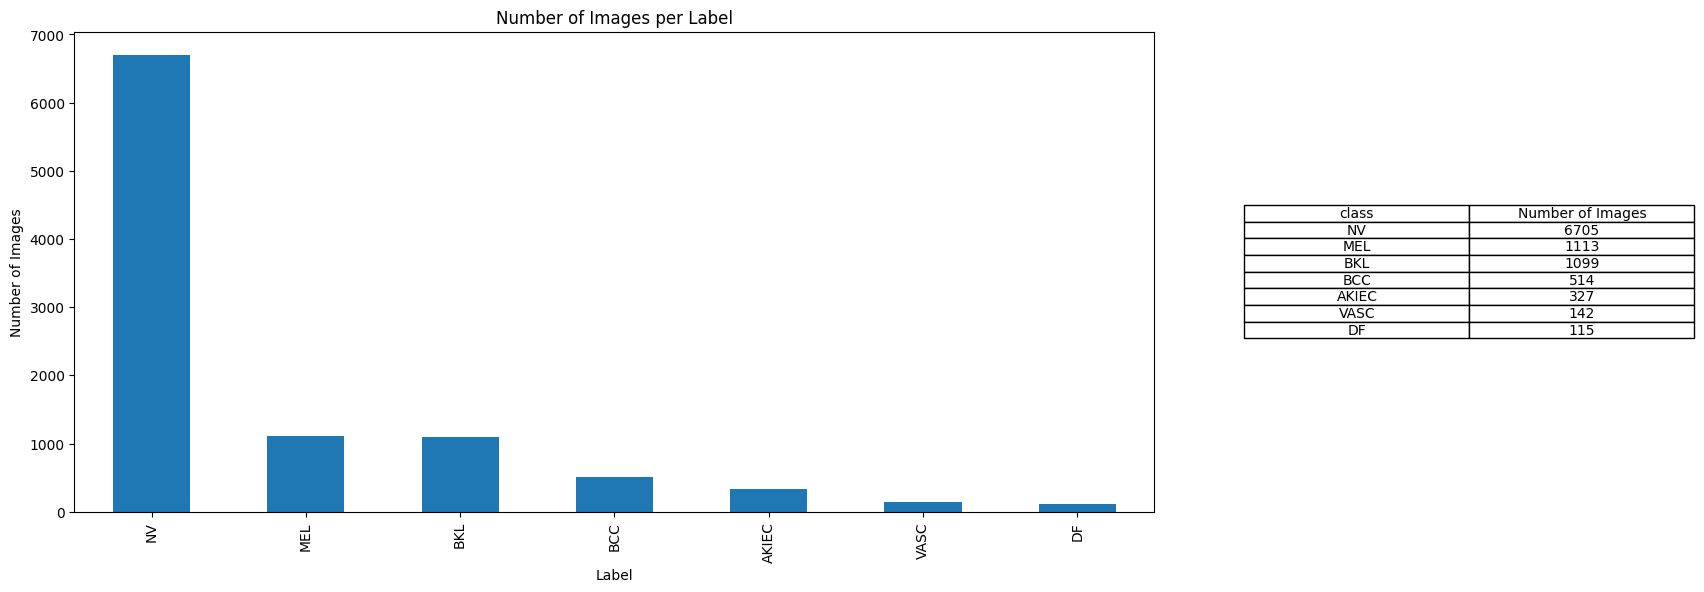

In [ ]:
def plot_label_distribution(df):
    label_counts = df['class'].value_counts()

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    label_counts.plot(kind='bar', ax=ax[0])
    ax[0].set_title('Number of Images per Label')
    ax[0].set_xlabel('Label')
    ax[0].set_ylabel('Number of Images')

    # Adjust the layout to make the plot 2/3 of the space
    ax[0].set_position([0.05, 0.1, 0.6, 0.8])
    ax[1].set_position([0.7, 0.1, 0.25, 0.8])

    ax[1].axis('off')
    ax[1].table(cellText=label_counts.reset_index().values, colLabels=['class', 'Number of Images'], cellLoc='center', loc='center')

    plt.show()

plot_label_distribution(skin_df)

In [ ]:
train_df, test_df = train_test_split(skin_df, test_size=0.2, stratify=skin_df['label'])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'])

In [ ]:
label_counts = pd.DataFrame({
    'Train': train_df['class'].value_counts(),
    'Validation': val_df['class'].value_counts(),
    'Test': test_df['class'].value_counts()
}).fillna(0).astype(int)

label_counts

Train  Validation  Test
class                         
NV      5364         670   671
MEL      890         111   112
BKL      879         110   110
BCC      411          51    52
AKIEC    262          33    32
VASC     114          14    14
DF        92          12    11

In [ ]:
def resampling(label_df, factor):
    if len(label_df) >= 5364:
        return label_df
    num_resamples = (2*len(label_df)) + (factor*len(label_df))
    resampled_df = label_df.sample(num_resamples, replace=True)
    return resampled_df

def resample_df(df, factors):
    resampled_dfs = []
    for label in df['class'].unique():
        label_df = df[df['class'] == label]
        resampled_df = resampling(label_df, factors[label])
        resampled_dfs.append(resampled_df)
    return pd.concat(resampled_dfs)

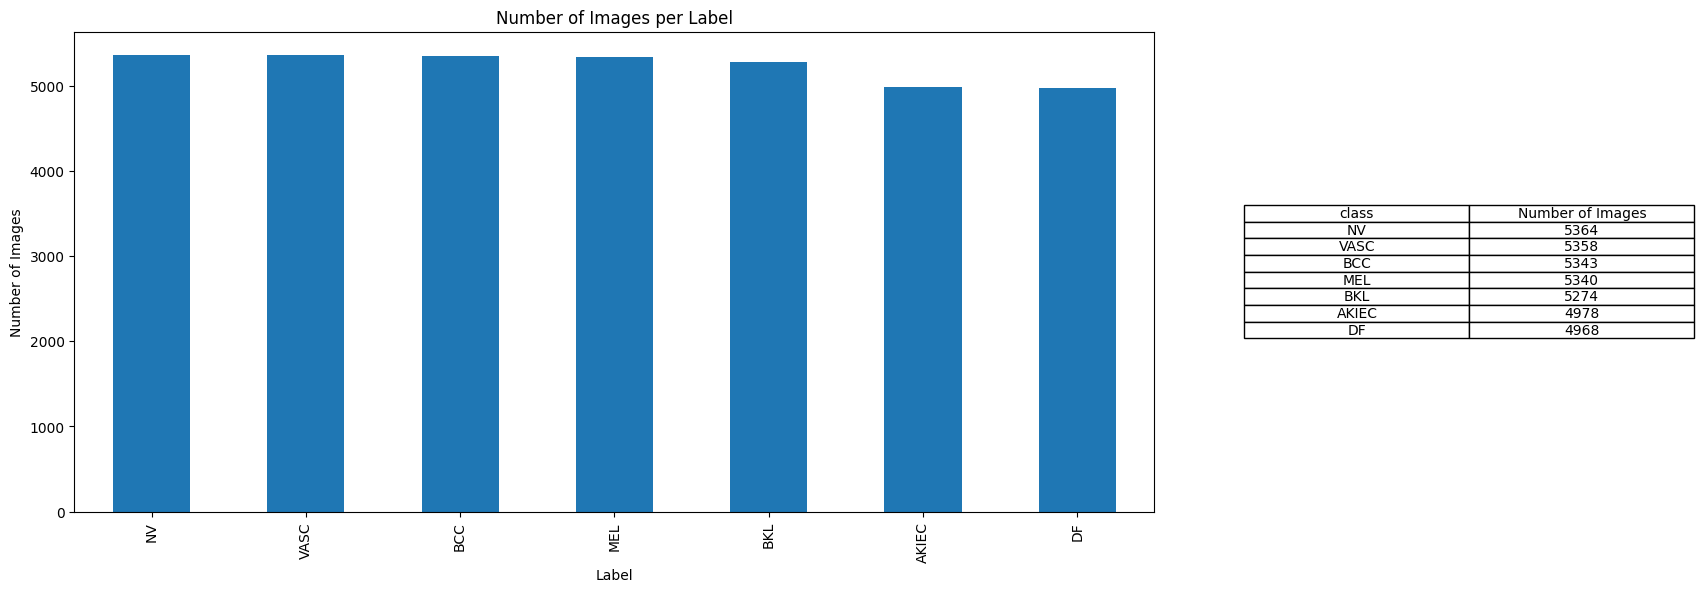

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'class',
       'label', 'path', 'mask_path'],
      dtype='object')
36625


In [ ]:
factors={"NV":0, "MEL":4, "BKL":4, "BCC":11, "AKIEC":17, "VASC":45, "DF":52}

train_df = resample_df(train_df, factors)
plot_label_distribution(train_df)
print(train_df.columns)
print(sum(train_df['image'].value_counts()))

In [ ]:
IMG_SIZE = 224
ROTATION = 20
CLASS_NAMES = sorted(train_df['class'].unique())
NO_AUGMENT_CLASSES = ['NV']

In [ ]:
def calculate_mean_std(image_paths):
    pixel_sum = np.zeros(3)
    pixel_squared_sum = np.zeros(3)
    total_pixels = 0

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]

        pixel_sum += img_array.sum(axis=(0, 1))
        pixel_squared_sum += (img_array ** 2).sum(axis=(0, 1))
        total_pixels += img_array.shape[0] * img_array.shape[1]

    mean = pixel_sum / total_pixels
    std = np.sqrt(pixel_squared_sum / total_pixels - mean ** 2)

    return mean, std

In [ ]:
MEAN, STD = calculate_mean_std(train_df['path'].tolist())
print("Mean:", MEAN)
print("Std:", STD)

In [ ]:
MEAN = [0.76320662, 0.54609609, 0.5705275 ]
STD = [0.14093064, 0.15281386, 0.17022888]

In [ ]:
augment_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATION),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

no_augment_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, type):
        self.dataframe = dataframe
        self.type = type

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 10]
        label = self.dataframe.iloc[idx, 9]
        img_class = self.dataframe.iloc[idx, 8]

        image = Image.open(img_path).convert("RGB")

        if img_class in NO_AUGMENT_CLASSES or self.type=='test' or self.type=='val':
            return no_augment_transform(image), label
        return augment_transform(image), label


In [ ]:
CLASS_COUNT = train_df['label'].value_counts().to_dict()
CLASS_COUNT = [CLASS_COUNT[label] for label in CLASS_NAMES]
CLASS_COUNT

[262, 411, 879, 92, 890, 5364, 114]

In [ ]:
def calculate_class_weights(class_counts):
    total_samples = sum(class_counts)  # Total number of samples
    class_weights = [total_samples / count for count in class_counts]  # Inverse frequency for each class
    class_weights_tensor = torch.tensor(class_weights).float()  # Convert to torch tensor
    return class_weights_tensor

In [ ]:
CLASS_WEIGHTS = calculate_class_weights(CLASS_COUNT)
CLASS_WEIGHTS

tensor([30.5802, 19.4939,  9.1149, 87.0870,  9.0022,  1.4937, 70.2807])

In [ ]:
def imshow(img, mean=MEAN, std=STD):
    img = img.clone().cpu().numpy()  # Move image to CPU and convert to numpy
    for i in range(img.shape[0]):  # Unnormalize each channel
        img[i] = img[i] * std[i] + mean[i]
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert CHW to HWC format
    plt.axis('off')  # Hide axis
    plt.show()

In [ ]:
train_dataset = CustomImageDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
val_dataset = CustomImageDataset(val_df, 'val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

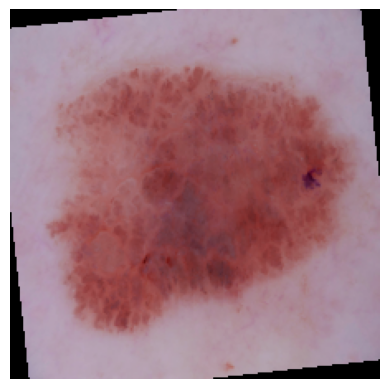

tensor(2)


In [ ]:
for images, labels in train_loader:
    imshow(images[0])
    print(labels[0])
    break

In [ ]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomResNet18, self).__init__()

        self.resnet18 = models.resnet18(weights=None)

        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

model = CustomResNet18(num_classes=7)
model = model.to('mps')
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of model parameters: {total_params}")

CustomResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion.to('mps')

num_epochs = 2
train_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training step
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")

    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss = running_loss / len(val_loader)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate
    scheduler.step(val_loss)

# Save the best model checkpoint after training
torch.save(best_model_state, "best_resnet18_ham10000.pth")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

Epoch [1/2], Step [0/1145], Loss: 0.1965, Accuracy: 90.62%
Epoch [1/2], Step [100/1145], Loss: 0.1458, Accuracy: 91.52%
Epoch [1/2], Step [200/1145], Loss: 0.2064, Accuracy: 91.51%
Epoch [1/2], Step [300/1145], Loss: 0.3355, Accuracy: 91.19%
Epoch [1/2], Step [400/1145], Loss: 0.1400, Accuracy: 91.32%
Epoch [1/2], Step [500/1145], Loss: 0.0658, Accuracy: 91.45%
Epoch [1/2], Step [600/1145], Loss: 0.0546, Accuracy: 91.64%
Epoch [1/2], Step [700/1145], Loss: 0.1283, Accuracy: 91.83%
Epoch [1/2], Step [800/1145], Loss: 0.4274, Accuracy: 91.72%
Epoch [1/2], Step [900/1145], Loss: 0.3830, Accuracy: 91.76%


KeyboardInterrupt: 

In [ ]:
def plot_training_curves(train_losses, train_accuracies, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    # Create subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training loss
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.set_title('Training and Validation Metrics Over Epochs')

    # Create a twin axis for accuracies
    ax2 = ax1.twinx()
    ax2.plot(epochs, train_accuracies, 'b--', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'g-.', label='Validation Accuracy', linewidth=2)
    ax2.set_ylabel('Accuracy (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Add a legend
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.15), ncol=3)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_training_curves(train_losses, train_accuracies, val_accuracies)


In [ ]:
torch.save(best_model_state,"/Users/shahdelrefai/Pattern Recognition/HAM10000/best_resnet18_ham10000.pth")

In [ ]:
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
best_model_state

In [ ]:
test_dataset = CustomImageDataset(test_df, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/var/folders/fz/20cl8zx17_g5rwwjnhb46z280000gn/T/ipykernel_1361/3383157302.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("/Users/sha

Total Loss: 0.7359
Overall Accuracy: 76.15%
Precision (macro-avg): 0.85
Recall (macro-avg): 0.62
F1 Score (macro-avg): 0.64

+---------+-------------+-----------+------------+-----------+---------+
| Class   |   Precision |    Recall |   F1 Score |   Correct |   Total |
+=========+=============+===========+============+===========+=========+
| AKIEC   |    0.794118 | 0.84375   |  0.818182  |        27 |      32 |
+---------+-------------+-----------+------------+-----------+---------+
| BCC     |    0.904762 | 0.730769  |  0.808511  |        38 |      52 |
+---------+-------------+-----------+------------+-----------+---------+
| BKL     |    0.714286 | 0.0454545 |  0.0854701 |         5 |     110 |
+---------+-------------+-----------+------------+-----------+---------+
| DF      |    0.909091 | 0.909091  |  0.909091  |        10 |      11 |
+---------+-------------+-----------+------------+-----------+---------+
| MEL     |    0.909091 | 0.0892857 |  0.162602  |        10 |     112 |

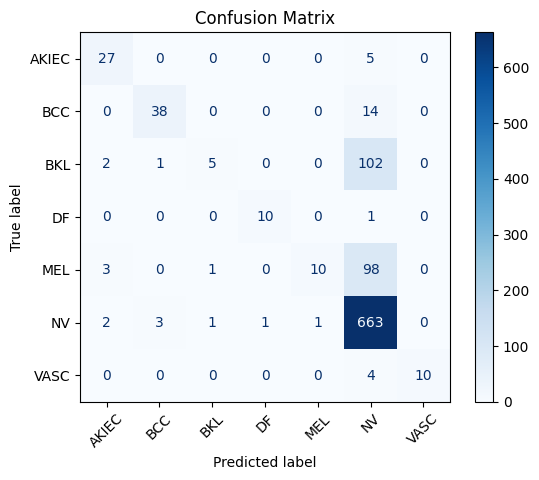


Class-wise Metrics:
Class: AKIEC
  Precision: 0.79, Recall: 0.84, F1 Score: 0.82
  Correct: 27 / Total: 32 samples
Class: BCC
  Precision: 0.90, Recall: 0.73, F1 Score: 0.81
  Correct: 38 / Total: 52 samples
Class: BKL
  Precision: 0.71, Recall: 0.05, F1 Score: 0.09
  Correct: 5 / Total: 110 samples
Class: DF
  Precision: 0.91, Recall: 0.91, F1 Score: 0.91
  Correct: 10 / Total: 11 samples
Class: MEL
  Precision: 0.91, Recall: 0.09, F1 Score: 0.16
  Correct: 10 / Total: 112 samples
Class: NV
  Precision: 0.75, Recall: 0.99, F1 Score: 0.85
  Correct: 663 / Total: 671 samples
Class: VASC
  Precision: 1.00, Recall: 0.71, F1 Score: 0.83
  Correct: 10 / Total: 14 samples
\Correct Predictions:
True label: NV, Predicted label: NV


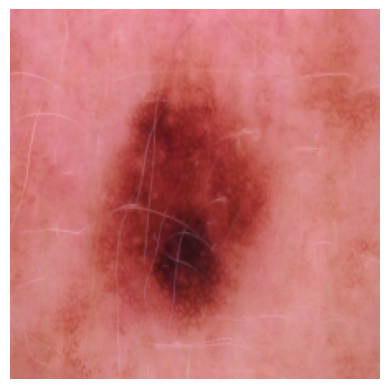

True label: AKIEC, Predicted label: AKIEC


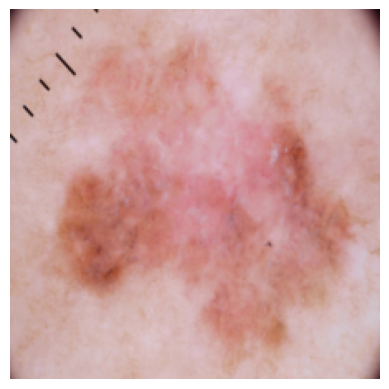

True label: VASC, Predicted label: VASC


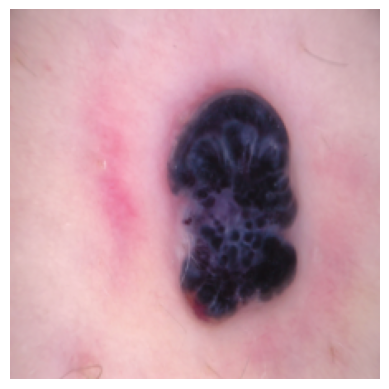

True label: BCC, Predicted label: BCC


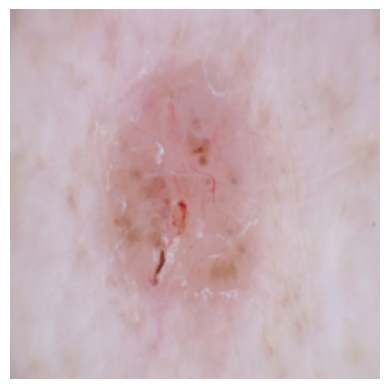

True label: DF, Predicted label: DF


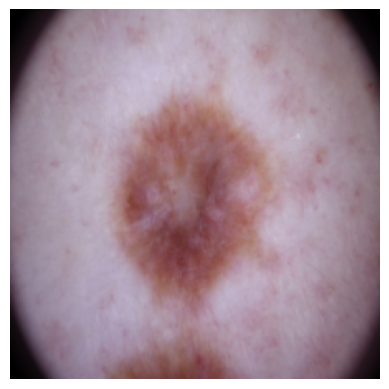

True label: MEL, Predicted label: MEL


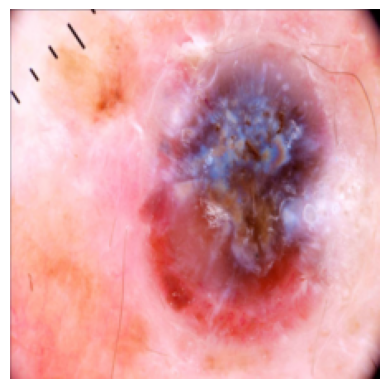

True label: BKL, Predicted label: BKL


True label: BCC, Predicted label: NV


True label: BKL, Predicted label: NV


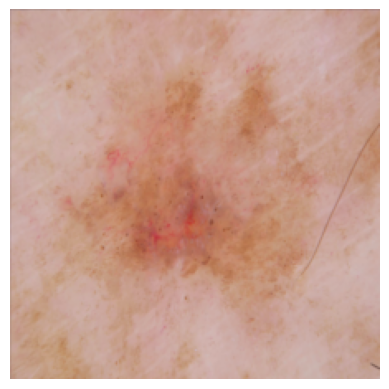

True label: MEL, Predicted label: NV


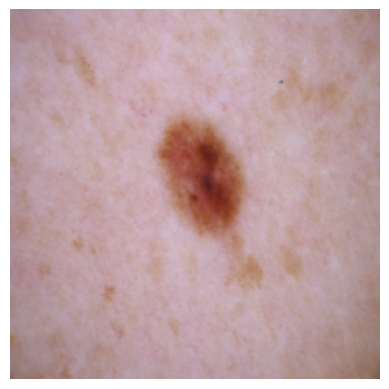

True label: AKIEC, Predicted label: NV


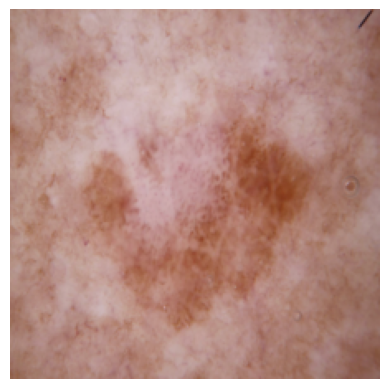

True label: NV, Predicted label: BCC


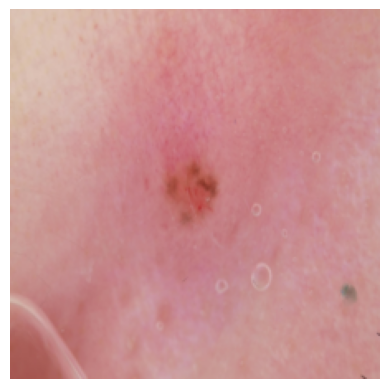

True label: VASC, Predicted label: NV


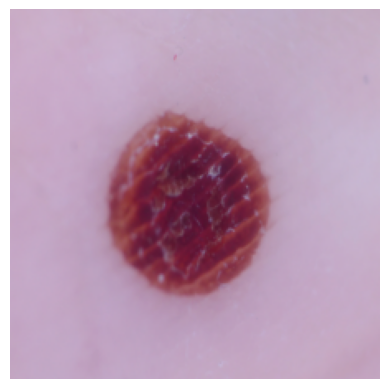

True label: DF, Predicted label: NV


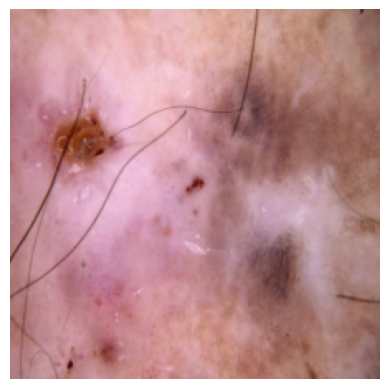

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

model2 = CustomResNet18(num_classes=7)
model2 = model2.to('mps')
model2.load_state_dict(torch.load("/Users/shahdelrefai/Pattern Recognition/HAM10000/best_resnet18_ham10000.pth"))

# Test function with detailed metrics
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []
    class_stats = defaultdict(lambda: {"correct": 0, "total": 0})
    incorrect_predictions = []
    total_loss = 0.0
    correct_images = []


    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update class-wise stats
            for i in range(len(labels)):
                true_class = labels[i].item()
                pred_class = predicted[i].item()
                class_stats[true_class]["total"] += 1
                if true_class == pred_class:
                    class_stats[true_class]["correct"] += 1
                    correct_images.append((inputs[i], class_names[true_class], class_names[pred_class]))
                else:
                    # Store incorrect predictions
                    incorrect_predictions.append((inputs[i], class_names[true_class], class_names[pred_class]))

    # Compute overall accuracy
    overall_accuracy = 100 * sum([class_stats[c]["correct"] for c in class_stats]) / len(all_preds)
    avg_loss = total_loss / len(test_loader)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=list(range(len(class_names))), zero_division=0)

    print(f"Total Loss: {avg_loss:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Precision (macro-avg): {precision.mean():.2f}")
    print(f"Recall (macro-avg): {recall.mean():.2f}")
    print(f"F1 Score (macro-avg): {f1.mean():.2f}\n")


    # Prepare class-wise metrics for table
    table_data = []
    for idx, cls in enumerate(class_names):
        correct = class_stats[idx]["correct"]
        total = class_stats[idx]["total"]
        table_data.append([cls, precision[idx], recall[idx], f1[idx], correct, total])

    # Print class-wise metrics table
    headers = ["Class", "Precision", "Recall", "F1 Score", "Correct", "Total"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Print metrics for each class
    print("\nClass-wise Metrics:")
    for idx, cls in enumerate(class_names):
        correct = class_stats[idx]["correct"]
        total = class_stats[idx]["total"]
        print(f"Class: {cls}")
        print(f"  Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}, F1 Score: {f1[idx]:.2f}")
        print(f"  Correct: {correct} / Total: {total} samples")

    print("\Correct Predictions:")
    found = []
    for img, true_label, pred_label in correct_images:
        if true_label not in found:
            print(f"True label: {true_label}, Predicted label: {pred_label}")
            imshow(img.cpu())
            found.append(true_label)
    found = []
    for img, true_label, pred_label in incorrect_predictions:
        if true_label not in found:
            print(f"True label: {true_label}, Predicted label: {pred_label}")
            imshow(img.cpu())
            found.append(true_label)


# Example usage
# Assuming you have already defined test_loader, class_names, and the model
test_model_with_metrics(model2, test_loader, CLASS_NAMES)


Total Loss: 0.4323
Overall Accuracy: 85.93%
Precision (macro-avg): 0.67
Recall (macro-avg): 0.69
F1 Score (macro-avg): 0.67

+---------+-------------+----------+------------+-----------+---------+
| Class   |   Precision |   Recall |   F1 Score |   Correct |   Total |
+=========+=============+==========+============+===========+=========+
| AKIEC   |    0.338983 | 0.625    |   0.43956  |        20 |      32 |
+---------+-------------+----------+------------+-----------+---------+
| BCC     |    0.666667 | 0.730769 |   0.697248 |        38 |      52 |
+---------+-------------+----------+------------+-----------+---------+
| BKL     |    0.609524 | 0.581818 |   0.595349 |        64 |     110 |
+---------+-------------+----------+------------+-----------+---------+
| DF      |    0.636364 | 0.636364 |   0.636364 |         7 |      11 |
+---------+-------------+----------+------------+-----------+---------+
| MEL     |    0.692308 | 0.5625   |   0.62069  |        63 |     112 |
+---------+

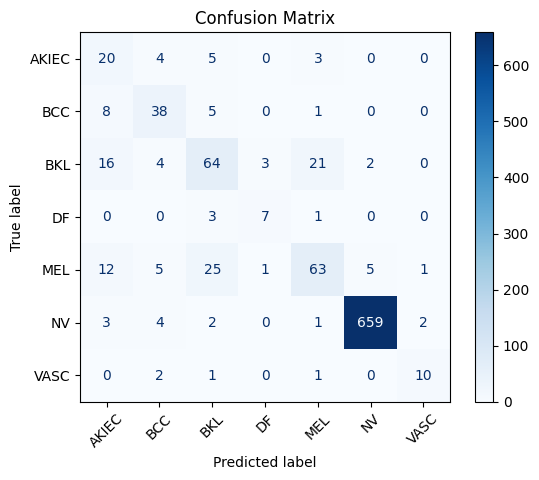

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import torch.nn.functional as F
from tabulate import tabulate

# Test function with detailed metrics and confusion matrix
def test_model_with_metrics(model, test_loader, class_names, criterion):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []
    class_stats = defaultdict(lambda: {"correct": 0, "total": 0})
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update class-wise stats
            for i in range(len(labels)):
                true_class = labels[i].item()
                pred_class = predicted[i].item()
                class_stats[true_class]["total"] += 1
                if true_class == pred_class:
                    class_stats[true_class]["correct"] += 1

    # Compute overall metrics
    overall_accuracy = 100 * sum([class_stats[c]["correct"] for c in class_stats]) / len(all_preds)
    avg_loss = total_loss / len(test_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=list(range(len(class_names))), zero_division=0)

    # Print overall metrics
    print(f"Total Loss: {avg_loss:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Precision (macro-avg): {precision.mean():.2f}")
    print(f"Recall (macro-avg): {recall.mean():.2f}")
    print(f"F1 Score (macro-avg): {f1.mean():.2f}\n")

    # Prepare class-wise metrics for table
    table_data = []
    for idx, cls in enumerate(class_names):
        correct = class_stats[idx]["correct"]
        total = class_stats[idx]["total"]
        table_data.append([cls, precision[idx], recall[idx], f1[idx], correct, total])

    # Print class-wise metrics table
    headers = ["Class", "Precision", "Recall", "F1 Score", "Correct", "Total"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

model2 = CustomResNet18(num_classes=7)
model2 = model2.to('mps')
model2.load_state_dict(torch.load("/Users/shahdelrefai/Pattern Recognition/HAM10000/best_resnet18_ham10000.pth", weights_only=False))
test_model_with_metrics(model2, test_loader, CLASS_NAMES, criterion)


In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class CustomResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomResNet50, self).__init__()

        self.resnet50 = models.resnet50(pretrained=True)

        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

model = CustomResNet50(num_classes=7)
model = model.to('mps')
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of model parameters: {total_params}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/shahdelrefai/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:48<00:00, 941kB/s] 


CustomResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion.to('mps')

num_epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training step
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")

    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss = running_loss / len(val_loader)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Update learning rate
    scheduler.step(val_loss)

# Save the best model checkpoint after training
torch.save(best_model_state, "best_resnet18_ham10000.pth")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

Epoch [1/10], Step [0/1145], Loss: 1.9764, Accuracy: 12.50%
Epoch [1/10], Step [100/1145], Loss: 1.2703, Accuracy: 52.20%
Epoch [1/10], Step [200/1145], Loss: 0.9289, Accuracy: 58.72%
Epoch [1/10], Step [300/1145], Loss: 0.8384, Accuracy: 61.95%
Epoch [1/10], Step [400/1145], Loss: 0.4902, Accuracy: 64.42%
Epoch [1/10], Step [500/1145], Loss: 0.8078, Accuracy: 66.45%
Epoch [1/10], Step [600/1145], Loss: 0.5066, Accuracy: 67.90%
Epoch [1/10], Step [700/1145], Loss: 0.7794, Accuracy: 69.14%
Epoch [1/10], Step [800/1145], Loss: 0.4042, Accuracy: 70.17%
Epoch [1/10], Step [900/1145], Loss: 0.2670, Accuracy: 71.13%
Epoch [1/10], Step [1000/1145], Loss: 0.5183, Accuracy: 72.06%
Epoch [1/10], Step [1100/1145], Loss: 0.2958, Accuracy: 72.85%
Epoch [1/10], Train Loss: 0.7221, Train Accuracy: 73.23%, Validation Accuracy: 89.11%
Epoch [2/10], Step [0/1145], Loss: 0.2901, Accuracy: 96.88%
Epoch [2/10], Step [100/1145], Loss: 0.4447, Accuracy: 82.49%
Epoch [2/10], Step [200/1145], Loss: 0.3436, Acc

KeyboardInterrupt: 

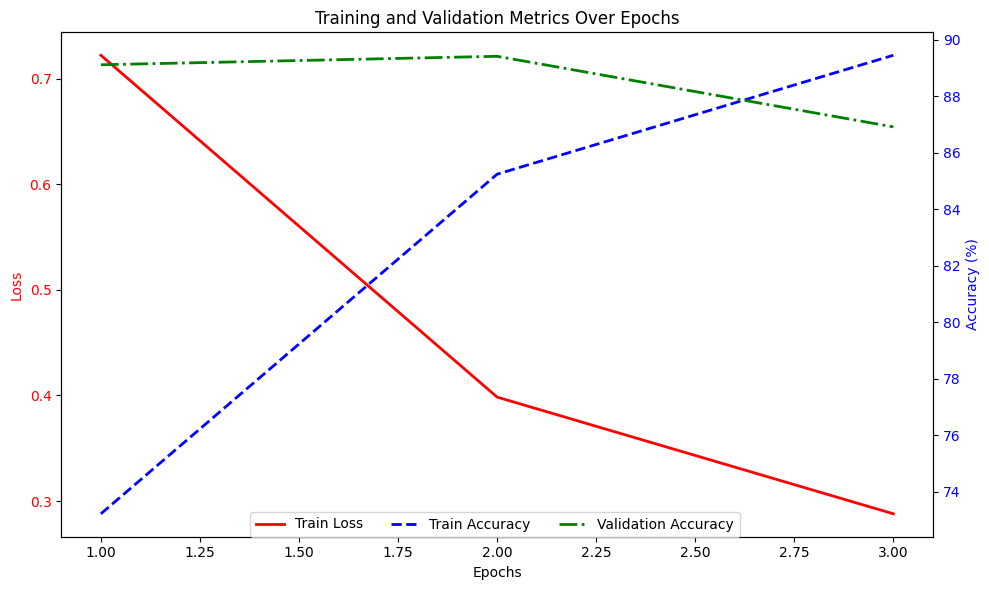

In [ ]:
plot_training_curves(train_losses, train_accuracies, val_accuracies)


In [ ]:
torch.save(best_model_state,"/Users/shahdelrefai/Pattern Recognition/HAM10000/best_resnet50_ham10000.pth")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/fz/20cl8zx17_g5rwwjnhb46z280000gn/T/ipykernel_7042/3844661208.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute 

Total Loss: 0.8279
Overall Accuracy: 75.25%
Precision (macro-avg): 0.75
Recall (macro-avg): 0.60
F1 Score (macro-avg): 0.59

+---------+-------------+-----------+------------+-----------+---------+
| Class   |   Precision |    Recall |   F1 Score |   Correct |   Total |
+=========+=============+===========+============+===========+=========+
| AKIEC   |    0.36     | 0.84375   |   0.504673 |        27 |      32 |
+---------+-------------+-----------+------------+-----------+---------+
| BCC     |    0.846154 | 0.423077  |   0.564103 |        22 |      52 |
+---------+-------------+-----------+------------+-----------+---------+
| BKL     |    0.537313 | 0.327273  |   0.40678  |        36 |     110 |
+---------+-------------+-----------+------------+-----------+---------+
| DF      |    1        | 0.636364  |   0.777778 |         7 |      11 |
+---------+-------------+-----------+------------+-----------+---------+
| MEL     |    0.857143 | 0.0535714 |   0.10084  |         6 |     112 |

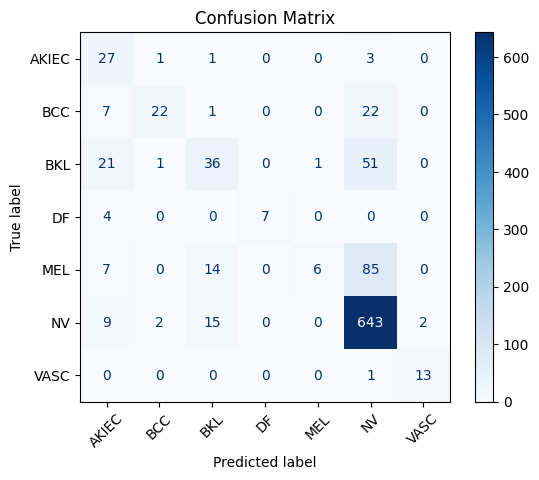


Class-wise Metrics:
Class: AKIEC
  Precision: 0.36, Recall: 0.84, F1 Score: 0.50
  Correct: 27 / Total: 32 samples
Class: BCC
  Precision: 0.85, Recall: 0.42, F1 Score: 0.56
  Correct: 22 / Total: 52 samples
Class: BKL
  Precision: 0.54, Recall: 0.33, F1 Score: 0.41
  Correct: 36 / Total: 110 samples
Class: DF
  Precision: 1.00, Recall: 0.64, F1 Score: 0.78
  Correct: 7 / Total: 11 samples
Class: MEL
  Precision: 0.86, Recall: 0.05, F1 Score: 0.10
  Correct: 6 / Total: 112 samples
Class: NV
  Precision: 0.80, Recall: 0.96, F1 Score: 0.87
  Correct: 643 / Total: 671 samples
Class: VASC
  Precision: 0.87, Recall: 0.93, F1 Score: 0.90
  Correct: 13 / Total: 14 samples
\Correct Predictions:
True label: NV, Predicted label: NV


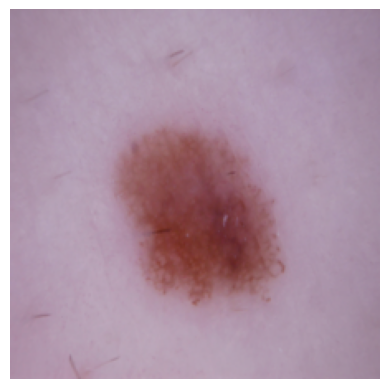

True label: BKL, Predicted label: BKL


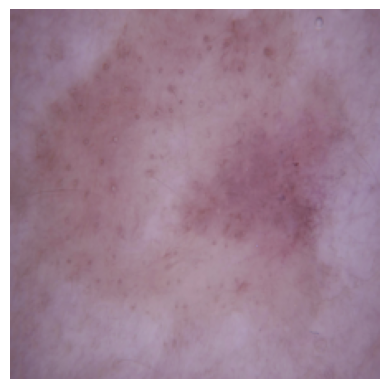

True label: DF, Predicted label: DF


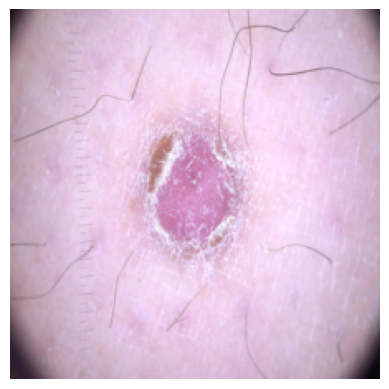

True label: BCC, Predicted label: BCC


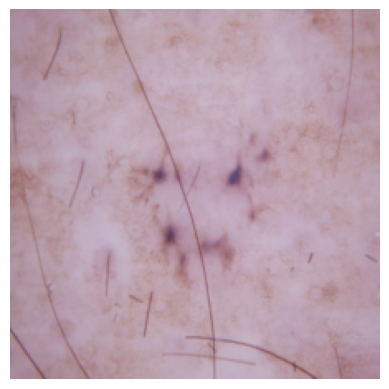

True label: VASC, Predicted label: VASC


True label: AKIEC, Predicted label: AKIEC


True label: MEL, Predicted label: MEL


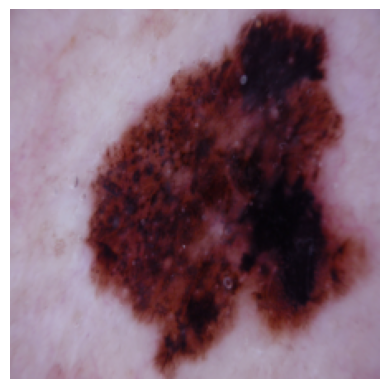

True label: BKL, Predicted label: NV


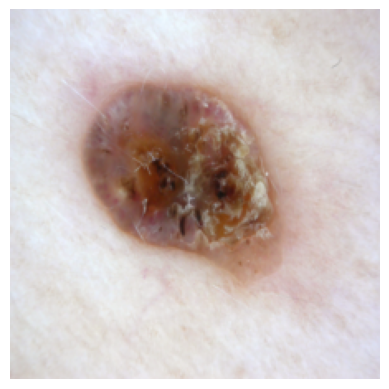

True label: MEL, Predicted label: NV


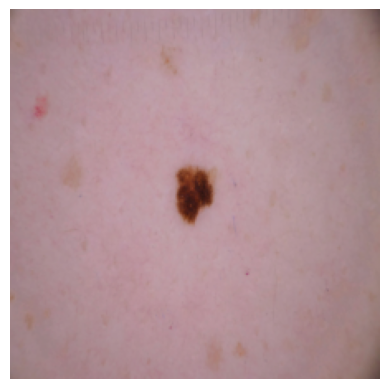

True label: BCC, Predicted label: NV


True label: AKIEC, Predicted label: BKL


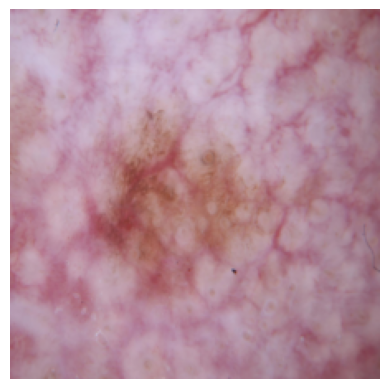

True label: NV, Predicted label: VASC


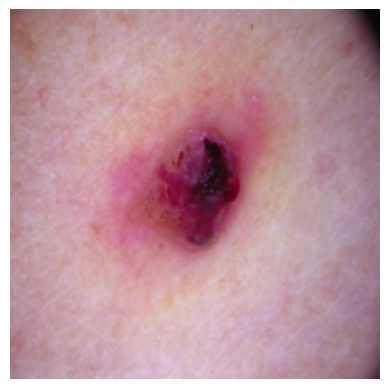

True label: DF, Predicted label: AKIEC


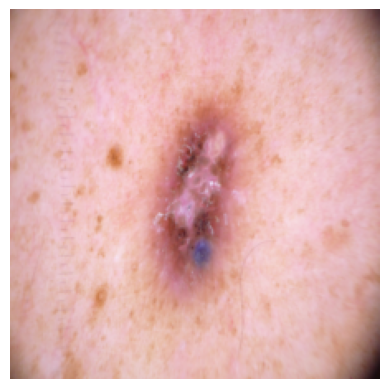

True label: VASC, Predicted label: NV


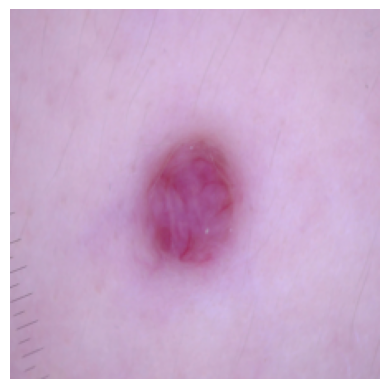

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

model2 = CustomResNet50(num_classes=7)
model2 = model2.to('mps')
model2.load_state_dict(torch.load("/Users/shahdelrefai/Pattern Recognition/HAM10000/best_resnet50_ham10000.pth"))

# Test function with detailed metrics
def test_model_with_metrics(model, test_loader, class_names):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []
    class_stats = defaultdict(lambda: {"correct": 0, "total": 0})
    incorrect_predictions = []
    total_loss = 0.0
    correct_images = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update class-wise stats
            for i in range(len(labels)):
                true_class = labels[i].item()
                pred_class = predicted[i].item()
                class_stats[true_class]["total"] += 1
                if true_class == pred_class:
                    class_stats[true_class]["correct"] += 1
                    correct_images.append((inputs[i], class_names[true_class], class_names[pred_class]))
                else:
                    # Store incorrect predictions
                    incorrect_predictions.append((inputs[i], class_names[true_class], class_names[pred_class]))

    # Compute overall accuracy
    overall_accuracy = 100 * sum([class_stats[c]["correct"] for c in class_stats]) / len(all_preds)
    avg_loss = total_loss / len(test_loader)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=list(range(len(class_names))), zero_division=0)

    print(f"Total Loss: {avg_loss:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Precision (macro-avg): {precision.mean():.2f}")
    print(f"Recall (macro-avg): {recall.mean():.2f}")
    print(f"F1 Score (macro-avg): {f1.mean():.2f}\n")


    # Prepare class-wise metrics for table
    table_data = []
    for idx, cls in enumerate(class_names):
        correct = class_stats[idx]["correct"]
        total = class_stats[idx]["total"]
        table_data.append([cls, precision[idx], recall[idx], f1[idx], correct, total])

    # Print class-wise metrics table
    headers = ["Class", "Precision", "Recall", "F1 Score", "Correct", "Total"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Print metrics for each class
    print("\nClass-wise Metrics:")
    for idx, cls in enumerate(class_names):
        correct = class_stats[idx]["correct"]
        total = class_stats[idx]["total"]
        print(f"Class: {cls}")
        print(f"  Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}, F1 Score: {f1[idx]:.2f}")
        print(f"  Correct: {correct} / Total: {total} samples")

    print("\Correct Predictions:")
    found = []
    for img, true_label, pred_label in correct_images:
        if true_label not in found:
            print(f"True label: {true_label}, Predicted label: {pred_label}")
            imshow(img.cpu())
            found.append(true_label)
    found = []
    for img, true_label, pred_label in incorrect_predictions:
        if true_label not in found:
            print(f"True label: {true_label}, Predicted label: {pred_label}")
            imshow(img.cpu())
            found.append(true_label)

# Example usage
# Assuming you have already defined test_loader, class_names, and the model
test_model_with_metrics(model2, test_loader, CLASS_NAMES)
